In [2]:
# Import required packages
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from osgeo import gdal
from datetime import datetime, timedelta
import time
import rasterio as rio
import xarray as xr
import rioxarray
import isce
import logging
root_logger = logging.getLogger()
root_logger.setLevel('WARNING')
import logging
from imageMath import IML
from components.contrib.geo_autoRIFT.autoRIFT import autoRIFT_ISCE
import isceobj
import time

In [3]:
os.environ['AUTORIFT'] = '/mnt/Backups/gbrench/sw/insar_tools/isce2/src/isce2/contrib/geo_autoRIFT'
os.environ['PYTHONPATH'] = os.environ['AUTORIFT']
os.environ['PATH'] += f":{os.environ['AUTORIFT']}"

In [4]:
scene_list=[
'S1A_IW_SLC__1SDV_20191004T121345_20191004T121412_029309_0354B0_F48E',
'S1A_IW_SLC__1SDV_20191016T121345_20191016T121412_029484_035ABB_373F',
'S1A_IW_SLC__1SDV_20191028T121345_20191028T121412_029659_0360C3_574E',
'S1A_IW_SLC__1SDV_20191109T121345_20191109T121412_029834_0366F3_462C',
'S1A_IW_SLC__1SDV_20191121T121344_20191121T121411_030009_036CFD_787C',
'S1A_IW_SLC__1SDV_20191203T121344_20191203T121411_030184_03730F_4C1A',
'S1A_IW_SLC__1SDV_20191215T121344_20191215T121411_030359_03791A_4B57',
'S1A_IW_SLC__1SDV_20191227T121343_20191227T121410_030534_037F23_3C47',
'S1A_IW_SLC__1SDV_20200108T121343_20200108T121410_030709_038533_C53D',
'S1A_IW_SLC__1SDV_20200120T121342_20200120T121409_030884_038B59_8828',
'S1A_IW_SLC__1SDV_20200201T121342_20200201T121409_031059_039174_1908',
'S1A_IW_SLC__1SDV_20200213T121341_20200213T121408_031234_039785_41EB',
'S1A_IW_SLC__1SDV_20200225T121341_20200225T121408_031409_039D91_8F87',
'S1A_IW_SLC__1SDV_20200308T121341_20200308T121408_031584_03A39B_6624',
'S1A_IW_SLC__1SDV_20200320T121342_20200320T121409_031759_03A9BC_08F7',
'S1A_IW_SLC__1SDV_20200401T121342_20200401T121409_031934_03AFE6_E721',
'S1A_IW_SLC__1SDV_20200413T121342_20200413T121409_032109_03B610_2EA6',
'S1A_IW_SLC__1SDV_20200425T121343_20200425T121410_032284_03BC35_898C'
           ]

In [5]:
proc_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12'

In [6]:
def select_pairs(scene_list, min_temp_bline, max_temp_bline):
    scene_dates = {}
    for scene in scene_list:
        date = scene[17:25]
        scene_dates[date] = scene

    pairs = []
    for date1 in scene_dates:
        for date2 in scene_dates:
            if datetime.strptime(date2, '%Y%m%d')-datetime.strptime(date1, '%Y%m%d') < timedelta(days=max_temp_bline) and not datetime.strptime(date2, '%Y%m%d')-datetime.strptime(date1, '%Y%m%d') < timedelta(days=min_temp_bline) and not date1 >= date2 :
                pairs.append([date1, date2])
    
    print(f'number of pairs: {len(pairs)}')
    
    return pairs

In [7]:
pairs = select_pairs(scene_list, 80, 360)

number of pairs: 66


In [8]:
def open_SLCs(pair):
    reference_fn = f'{proc_path}/work/merged/SLC/{pair[0]}/{pair[0]}.slc.full'
    secondary_fn = f'{proc_path}/work/merged/SLC/{pair[1]}/{pair[1]}.slc.full'

    ds1 = gdal.Open(reference_fn, gdal.GA_ReadOnly)
    slc1 = ds1.GetRasterBand(1).ReadAsArray()

    ds2 = gdal.Open(secondary_fn, gdal.GA_ReadOnly)
    slc2 = ds2.GetRasterBand(1).ReadAsArray()

    I1 = np.abs(slc1)
    I2 = np.abs(slc2)

    return I1, I2

In [17]:
def run_autoRIFT(pair, preproc_filter_width=5, multithread_count=12, min_chip=8, max_chip=32, skip_x=31, skip_y=5):

    print(f'working on  {pair}')
    
    I1, I2 = open_SLCs(pair)

    obj = autoRIFT_ISCE()
    obj.configure()

    obj.WallisFilterWidth = preproc_filter_width

    obj.MultiThread = multithread_count

    obj.I1 = I1
    obj.I2 = I2

    obj.ChipSizeMinX = min_chip
    obj.ChipSizeMaxX = max_chip
    obj.ChipSize0X = min_chip
    obj.SkipSampleX = skip_x
    obj.SkipSampleY = skip_y

    m,n = obj.I1.shape
    xGrid = np.arange(obj.SkipSampleX+10,n-obj.SkipSampleX,obj.SkipSampleX)
    yGrid = np.arange(obj.SkipSampleY+10,m-obj.SkipSampleY,obj.SkipSampleY)
    nd = xGrid.__len__()
    md = yGrid.__len__()
    obj.xGrid = np.int32(np.dot(np.ones((md,1)),np.reshape(xGrid,(1,xGrid.__len__()))))
    obj.yGrid = np.int32(np.dot(np.reshape(yGrid,(yGrid.__len__(),1)),np.ones((1,nd))))
    noDataMask = np.logical_not(obj.xGrid)
    
    obj.SearchLimitX = obj.SearchLimitX * np.logical_not(noDataMask)
    obj.SearchLimitY = obj.SearchLimitY * np.logical_not(noDataMask)
    obj.Dx0 = obj.Dx0 * np.logical_not(noDataMask)
    obj.Dy0 = obj.Dy0 * np.logical_not(noDataMask)

    obj.xGrid[noDataMask] = 0
    obj.yGrid[noDataMask] = 0
    obj.Dx0[noDataMask] = 0
    obj.Dy0[noDataMask] = 0
    obj.SearchLimitX[noDataMask] = 0
    obj.SearchLimitY[noDataMask] = 0
    
    # convert az 
    obj.Dy0 = -1 * obj.Dy0

    print(f'preprocessing')
    obj.preprocess_filt_wal()
    obj.uniform_data_type()

    # not totally sure what this does yet
    #obj.OverSampleRatio = {obj.ChipSize0X:32,obj.ChipSize0X*2:64,obj.ChipSize0X*4:128,obj.ChipSize0X*8:128}

    print('running autoRIFT')
    obj.runAutorift()

    return obj #.Dx, obj.Dy, obj.InterpMask, obj.ChipSizeX, obj.GridSpacingX, obj.ScaleChipSizeY, obj.origSize, noDataMask

In [18]:
obj = run_autoRIFT(pairs[5])

working on  ['20191004', '20200225']
preprocessing


/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:71: RuntimeWarning: invalid value encountered in divide
  self.I1 = (self.I1 - m) / s
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:83: RuntimeWarning: invalid value encountered in divide
  self.I2 = (self.I2 - m) / s
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:225: RuntimeWarning: invalid value encountered in cast
  self.I1 = np.round(np.clip(self.I1, 0, 255)).astype(np.uint8)
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:238: RuntimeWarning: invalid value encountered in cast
  self.I2 = np.round(np.clip(self.I2, 0, 255)).astype(np.uint8)


running autoRIFT


/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1413: RuntimeWarning: All-NaN slice encountered
  D = np.nanmedian(B,axis=0)
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1416: RuntimeWarning: All-NaN slice encountered
  C = np.nanmedian(D,axis=0, overwrite_input=True)
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1403: RuntimeWarning: All-NaN slice encountered
  C = np.nanmedian(B,axis=0, overwrite_input=True)
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site-packages/isce/components/contrib/geo_autoRIFT/autoRIFT/autoRIFT.py:1468: RuntimeWarning: divide by zero encountered in divide
  DxMadmin = np.ones(Dx.shape) / OverSampleRatio / SearchLimitX * 2;
/mnt/Backups/gbrench/sw/miniconda3/envs/insar/lib/python3.11/site

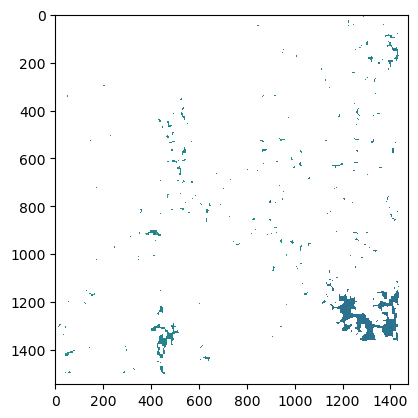

In [20]:
f, ax = plt.subplots()
ax.imshow(obj.Dx)

In [ ]:
os.makedirs(f'{proc_path}/offsets', exist_ok=True)
reference_fn = f'{proc_path}/work/merged/SLC/{pairs[14][0]}/{pairs[14][0]}.slc.full'
secondary_fn = f'{proc_path}/work/merged/SLC/{pairs[14][1]}/{pairs[14][1]}.slc.full'
#out_fn = f'{proc_path}/offsets/{pairs[14][0]}_{pairs[14][1]}.nc'
!testautoRIFT_ISCE.py -m {reference_fn} -s{secondary_fn} -mpflag 12 -nc S1

In [ ]:
ds = xr.open_dataset('autoRIFT_intermediate.nc')

In [ ]:
dem_fn = f'{proc_path}/work/merged/geom_reference/hgt.rdr.full'
dem_ds = gdal.Open(dem_fn, gdal.GA_ReadOnly)
dem = dem_ds.GetRasterBand(1).ReadAsArray()

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(np.flip(ds.Dx.values, (0))[30:280, 350:750], cmap='RdBu_r', vmin=-3, vmax=3, interpolation='none')
ax[0].set_title(f'slant range offsets, {pairs[14][0]}-{pairs[14][1]}, 5 skip az 31 skip rg')
ax[0].set_aspect(1)

ax[1].imshow(np.flip(dem, (0))[0:1500, 10000:25000], vmin=3000, vmax=8000)
ax[1].set_title(f'COP30 DEM')
ax[1].set_aspect(6.13)

f.tight_layout()